In [33]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [34]:
data = pd.read_csv("data.csv")
#remove the first row because it is 'nan'
texts = data["Message"].tolist()[1:]
labels = data["Category"].tolist()[1:]
print(texts)
print(labels)


['Make a gap so you can weave on this straight and then we’ll have a lift and brake into 11.', 'We’ll need a 1.50 lift into turn 10.', 'Brake into 8. Easy through 8.', 'No full pedal from now.', 'I have understeer at turn 80 and oversteer at turn 80.', 'Everything is overheating.', 'I don’t like the feedback on the start. Yeah, it’s too deep.', 'Front’s still too cold. Just had a test.', 'This tyre sucks.', 'We are boxing for hard tyres.', 'Keep working those tyres.', 'Focusing on putting temperature on these tyres.', 'Medium tyres through 11 and 12.', 'Our tyres are on mode 3A.', 'box box box.', 'Plan 12. Plus 0.5.', 'We are plan B, target lap, both safety car windows are open.', 'We’ll box this lap.', 'Next tyres will be a hard ollie.', 'You have clear, clear now. The car ahead is Stroll in turn 2.', 'Wind is reducing. Wind is reduced 5 kph.', 'Everyone slow ahead.', 'Lando is over his grid box.', 'Isaac has DRS behind.', 'WooHoo, let’s go baby! Love that.', 'I am stupid. I switching

In [35]:
tokenized = [text.lower().split() for text in texts]
word2idx = {}
idx2word = {}
idx = 0
for sentence in tokenized:
    for word in sentence:
        if word not in word2idx:
            word2idx[word] = idx
            idx2word[idx] = word
            idx += 1
vocab_size = len(word2idx)

In [36]:
label2idx = {
    "차량 조작 지시": 0,
    "차량 상태 피드백": 1,
    "타이어 관련": 2,
    "전략 및 계획": 3,
    "트랙/상대 정보": 4,
    "감성/개인 표현": 5,
    "시스템/하드웨어 문제": 6,
    "데이터 피드백/비교": 7
}
idx2label = {v: k for k, v in label2idx.items()}

In [37]:
X_data = []
y_data = []

for sentence, label in zip(tokenized, labels):
    context_vec = np.zeros(vocab_size)
    for word in sentence:
        context_vec[word2idx[word]] += 1
    X_data.append(context_vec / len(sentence))
    y_data.append(label)

X = np.array(X_data)
y = [label2idx[label] for label in labels]
num_classes = len(set(y))

In [38]:
embedding_dim = 16
W_embed = np.random.randn(vocab_size, embedding_dim) * 0.01  # 단어 임베딩
W_out = np.random.randn(embedding_dim, num_classes) * 0.01   # 출력 가중치
b_out = np.zeros((1, num_classes))
learning_rate = 0.01

In [39]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy(probs, y_true):
    batch_size = probs.shape[0]
    log_probs = np.log(probs + 1e-9)
    loss = -log_probs[range(batch_size), y_true].mean()
    return loss

In [40]:
def train_test_split(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split = int(len(X) * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    return (
        np.array([X[i] for i in train_idx]),  # Convert to NumPy array
        np.array([X[i] for i in test_idx]),  # Convert to NumPy array
        [y[i] for i in train_idx],
        [y[i] for i in test_idx]
    )

Epoch 0 | Loss: 2.0795
Epoch 10000 | Loss: 1.9983
Epoch 20000 | Loss: 0.4427
Epoch 30000 | Loss: 0.0626
Epoch 40000 | Loss: 0.0255
Epoch 50000 | Loss: 0.0149
Epoch 60000 | Loss: 0.0103
Epoch 70000 | Loss: 0.0077
Epoch 80000 | Loss: 0.0061
Epoch 90000 | Loss: 0.0050


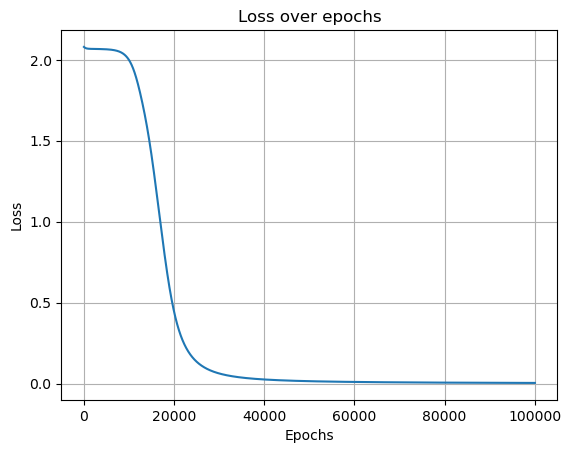

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
epochs = 100000
losses = []

for epoch in range(epochs):
    # 1) 임베딩 평균화
    X_embed = np.dot(X_train, W_embed)  # shape: (batch_size, embedding_dim)

    # 2) 출력 계산
    logits = np.dot(X_embed, W_out) + b_out
    probs = softmax(logits)

    # 3) 손실
    loss = cross_entropy(probs, y_train)
    losses.append(loss)
    # 4) 역전파
    N = X_train.shape[0]
    one_hot = np.zeros_like(probs)
    one_hot[np.arange(N), y_train] = 1
    dL_dz = (probs - one_hot) / N

    dW_out = np.dot(X_embed.T, dL_dz)
    db_out = np.sum(dL_dz, axis=0, keepdims=True)

    dX_embed = np.dot(dL_dz, W_out.T)  # shape: (N, embedding_dim)
    dW_embed = np.dot(X_train.T, dX_embed)  # shape: (vocab_size, embedding_dim)

    # 5) 파라미터 업데이트
    W_out -= learning_rate * dW_out
    b_out -= learning_rate * db_out
    W_embed -= learning_rate * dW_embed

    if epoch % 10000 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f}")

plt.plot(losses)
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [43]:
test_logits = np.dot(np.dot(X_test, W_embed), W_out) + b_out
test_probs = softmax(test_logits)  # Softmax to get probabilities
preds = np.argmax(test_probs, axis=1)  # Predicted class

labels = list(idx2label.keys())

# 使用 labels 参数生成分类报告
report = classification_report(y_test, preds, labels=labels, target_names=idx2label.values(), output_dict=True)

# 打印分类报告
print("Classification Report:")
print(classification_report(y_test, preds, labels=labels, target_names=idx2label.values()))

Classification Report:
              precision    recall  f1-score   support

    차량 조작 지시       0.00      0.00      0.00         0
   차량 상태 피드백       0.00      0.00      0.00         1
      타이어 관련       0.50      1.00      0.67         1
     전략 및 계획       1.00      0.50      0.67         2
    트랙/상대 정보       0.00      0.00      0.00         2
    감성/개인 표현       1.00      1.00      1.00         1
 시스템/하드웨어 문제       0.00      0.00      0.00         0
  데이터 피드백/비교       1.00      1.00      1.00         1

    accuracy                           0.50         8
   macro avg       0.44      0.44      0.42         8
weighted avg       0.56      0.50      0.50         8



d:\conda\envs\aimath\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\aimath\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\aimath\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\conda\envs\aimath\Lib\site-packages\sklearn\metric

In [ ]:
# new data 예측
new_texts = [
    "box box box", 
    "My tyres are gone.",
    "Tell him to get out of the way.",
    "We need to push for track position.",
    
]


# 1. 分词并向量化
new_tokenized = [text.lower().split() for text in new_texts]
new_X_data = []

for sentence in new_tokenized:
    context_vec = np.zeros(vocab_size)
    for word in sentence:
        if word in word2idx:  # if in vocabulary
            context_vec[word2idx[word]] += 1
    new_X_data.append(context_vec / len(sentence))

new_X = np.array(new_X_data)

new_X_embed = np.dot(new_X, W_embed)

new_logits = np.dot(new_X_embed, W_out) + b_out
new_probs = softmax(new_logits)

new_y_pred = np.argmax(new_probs, axis=1)

new_y_pred_labels = [idx2label[idx] for idx in new_y_pred]

for text, label in zip(new_texts, new_y_pred_labels):
    print(f"Text: \"{text}\" | Predicted Label: \"{label}\"")

Text: "box box box" | Predicted Label: "전략 및 계획"
Text: "My tyres are gone." | Predicted Label: "타이어 관련"
Text: "Tell him to get out of the way." | Predicted Label: "차량 상태 피드백"
Text: "We need to push for track position." | Predicted Label: "타이어 관련"


In [ ]:
import pickle

model_data = {
    "W_embed": W_embed,
    "W_out": W_out,
    "b_out": b_out,
    "word2idx": word2idx,
    "idx2label": idx2label,
    "vocab_size": vocab_size,
    "embedding_dim": embedding_dim,
    "num_classes": num_classes
}

with open("cbow_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Model saved successfully!")

Model saved successfully!
